# Smash Ultimate Viewership Analysis

Hi. In this notebook I will begin analyzing smash ultimate viewership data. My goal is to identify trends in viewershp and help the smash scene expand its fanbase. This notebook is written in python and is running inside a jupyter notebook. I will not explain my code in great detail, but I will describe what each block of code does at a high level. The focus of this analysis is on character diversity and its impact on video views. Lets get started!

First let's import some useful libraries. These will make analysis faster down the line

In [1]:
import pandas as pd
import requests
import json
from io import StringIO
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import re
pd.options.display.max_colwidth=200
pd.set_option('display.max_rows',200)

To begin this analysis, we need to gather video data from youtube. Normally this is done with Youtube Data API, but using the API requires creating a google console account and creating your own API_KEY. to save time and to prevent having to request the same informsation multiple times, I stored the relevant data in smash_supermajor_set_info.csv. This csv contains data on every taped set from the 11 largest smash ultimate tournaments. The data was requested in early June 2020. If you want to get the data yourself use the gather_smash_ultimate_videos(api_key) function. However, for most people the csv should provide everything they need.



tl;dr the next four blocks of code are about gathering data

In [2]:
#Insert your API key within the double quotes
API_KEY=""

In [3]:
#This function gathers data directly from youtube. You will need an API key to use it 
def gather_smash_ultimate_videos(api_key):
    smash_data="""Rank,Name,Date,Entrants,Winner,Youtube_Playlist_ID
    1,EVO 2019,"August 2nd-4th, 2019","3,534",MkLeo,PLcMdMmtHkPpQX3Gkwse0Ptgkmzm5OhoHZ
    2,Super Smash Con 2019,August 8th-11th 2019,"2,708",MkLeo,PLcMdMmtHkPpT154Vl0sb7Seo5fqj7jyvz
    3,GENESIS 6,"February 1st-3rd, 2019","2,105",MkLeo,PLcMdMmtHkPpRcLptz1CA5GHU3LtbO7DNX
    4,EVO Japan 2020,"January 24th-26th, 2020","1,819",Shuton,PLngX9JPOCelZ3UEcPc8MHCk-DDLo3mk6f
    5,GENESIS 7,"January 24th-26th, 2020","1,699",Marss,PLCR3KcbG-XGuwSWV2O88CGH4sP_l1m61R
    6,Smash 'N' Splash 5,"May 31st-June 2nd, 2019","1,610",MkLeo,PLcMdMmtHkPpTudntthjfaWbteUcj1RGvF
    7,Frostbite 2020,"February 21st-23rd, 2019","1,280",MkLeo,PLcMdMmtHkPpTfUyp8O-4JME0VwekNUCaR
    8,Frostbite 2019,"February 22nd-24th, 2019","1,239",Tweek,PLdA_P2NSglcg6kgh2z6GinTQUldVfVaam
    9,CEO 2019,June 28th-30th 2019,"1,164",MkLeo,PLcMdMmtHkPpSjtPeJlrclN0BsDDJfh9Bz
    10,The Big House 9,"October 4th-6th, 2019","1,017",Zackray,PLCR3KcbG-XGvV9HM4V_enegPUZq7RVgss
    11,Umebura Japan Major 2019,"May 1st-2nd, 2019","1,015",kameme,PLcMdMmtHkPpSxyhjVHhAjO9lVVhrrEsSC"""
    csv_formatting=StringIO(smash_data)
    smash_tournament_info=pd.read_csv(csv_formatting)
    tournamentt_dict={}
    for i in range(len(smash_tournament_info)):
        tournament_dict[smash_tournament_info.iloc[i,1]]=smash_tournament_info.iloc[i,5]
    video_dataframe=pd.DataFrame(columns=['video_title','video_length','video_views','published_date','tournament'])
    columns=video_dataframe.columns
    for key, value in tournament_dict.items():
        
        playlistItems = json.loads(requests.get("https://www.googleapis.com/youtube/v3/playlistItems?part=contentDetails&key={}&playlistId={}&maxResults=50".format(api_key,value)).text)
        videos=playlistItems['items']
        for i in videos:
            contentDetails=i['contentDetails']
            videoID=contentDetails['videoId']
            videoInfo = json.loads(requests.get("https://www.googleapis.com/youtube/v3/videos?part=snippet,contentDetails,statistics&key={}&id={}".format(api_key,videoID)).text)
            videoTitle=videoInfo['items'][0]['snippet']['title']
            videoLength=videoInfo['items'][0]['contentDetails']['duration']
            videoViews=videoInfo['items'][0]['statistics']['viewCount']
            videoPublishDate=videoInfo['items'][0]['snippet']['publishedAt']
            newEntry=pd.Series([videoTitle,videoLength,videoViews,videoPublishDate,key],index=columns)
            video_dataframe=video_dataframe.append(newEntry, ignore_index=True)
        while 'nextPageToken' in playlistItems:
            nextpageToken=playlistItems['nextPageToken']
            playlistItems = json.loads(requests.get("https://www.googleapis.com/youtube/v3/playlistItems?part=contentDetails&key={}&playlistId={}&maxResults=50&pageToken={}".format(api_key,value,nextpageToken)).text)
            videos=playlistItems['items']
            for i in videos:
                contentDetails=i['contentDetails']
                videoID=contentDetails['videoId']
                videoInfo = json.loads(requests.get("https://www.googleapis.com/youtube/v3/videos?part=snippet,contentDetails,statistics&key={}&id={}".format(api_key,videoID)).text)
                videoTitle=videoInfo['items'][0]['snippet']['title']
                videoLength=videoInfo['items'][0]['contentDetails']['duration']
                videoViews=videoInfo['items'][0]['statistics']['viewCount']
                videoPublishDate=videoInfo['items'][0]['snippet']['publishedAt']
                newEntry=pd.Series([videoTitle,videoLength,videoViews,videoPublishDate,key],index=columns)
                video_dataframe=video_dataframe.append(newEntry, ignore_index=True)
        
    return video_dataframe


In [4]:
#uncomment the following line of code and add your API Key to gather data directly from Youtube
#gather_smash_ultimate_videos(API_KEY)

In [5]:
#the below line of_code gathers data from the csv containing video view data
smash_videos=pd.read_csv('smash_supermajor_set_info.csv')

We gathered the data and stored it in a dataframe (dataframes are like tables). Let's take a lokk at some sample rows to get an idea what we are working with

In [6]:
smash_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 5 columns):
video_title       1139 non-null object
video_length      1139 non-null object
video_views       1139 non-null int64
published_date    1139 non-null object
tournament        1139 non-null object
dtypes: int64(1), object(4)
memory usage: 44.6+ KB


In [7]:
smash_videos.sample(25)

,video_title,video_length,video_views,published_date,tournament
159,Frostbite 2020 SSBU Losers Top 12 - MkLeo (Joker) Vs. NRG | Nairo (Palutena) Smash Ultimate Singles,PT19M25S,178659,2020-02-24T00:03:07Z,Frostbite 2020
449,saj. (Daisy/Peach) vs. Ronin (Pichu) - Ultimate Pools - Frostbite 2019,PT11M59S,1097,2019-02-23T17:08:35Z,Frostbite 2019
746,Sekai Doggo vs insomniac - Ultimate Singles: Pools Winners' Finals - Genesis 7,PT15M9S,1448,2020-01-24T22:22:02Z,GENESIS 7
74,Frostbite 2020 SSBU Pools - Liquid | Dabuz (Olimar) Vs. WP | Suinoko (Young Link) Ultimate Singles,PT8M25S,6070,2020-02-22T23:57:29Z,Frostbite 2020
693,CEO 2019 SSBU - Wrath (Joker) Vs. SL | Osiris197 (Falco) Smash Ultimate Tournament Top 192 Losers,PT9M20S,2890,2019-06-29T18:13:03Z,CEO 2019
566,eU | Samsora (Peach) vs. Armada | Ned (Pokemon Trainer) - Ultimate Top 48 - Frostbite 2019,PT19M11S,8789,2019-02-24T22:37:36Z,Frostbite 2019
882,Marss vs Prodigy - Ultimate Singles: Top 64 Winners Round 2 - Genesis 7 | ZSS vs Mario,PT10M37S,13116,2020-01-26T06:45:56Z,GENESIS 7
1116,"[OFFSTREAM] EVO 2019 SSBU - NRG | Nairo (Palutena) Vs. kept (Isabelle, Villager) Smash Ultimate LT32",PT16M42S,9762,2019-08-20T18:00:00Z,EVO 2019
657,CEO 2019 SSBU - Ally (Snake) Vs. FP | Kiwi (Pac-Man) Smash Ultimate Tournament Pools,PT17M15S,12347,2019-06-28T21:59:01Z,CEO 2019
1009,SNS5 SSBU - Armada | Ned (Chrom) Vs. Gomakenpi (Olimar) Smash Ultimate Tournament Division 2 Winners,PT9M11S,950,2019-06-01T19:27:46Z,Smash 'N' Splash 5


The dataframe contains 5 columns and 1139 rows. Each row represents a video, and each column represents information we know about the video. Most of the columns should be self explanatory. The video length may look weird, but it's just representing the time in a weird format. I will convert it in the next cell block into an HH:MM:SS format, but if you are curious PT stands for playtime, H stands for Hour, M stands for minute, and S stands for second.

In [8]:
testing=smash_videos.video_length
testing=testing.apply(lambda x: x[2:])
testing=testing.apply(lambda x: x if 'S' in x else x+'0S')
testing=testing.apply(lambda x: x if 'M' in x else '0M'+x)
testing=testing.apply(lambda x: x if 'H' in x else '0H'+x)
smash_videos.video_length=testing.apply(lambda x: datetime.strptime(x,'%HH%MM%SS'))
smash_videos.video_length=smash_videos.video_length.apply(lambda x: timedelta(hours=x.hour,minutes=x.minute,seconds=x.second))
smash_videos.sample(20)

,video_title,video_length,video_views,published_date,tournament
1123,"EVO 2019 SSBU - TL | Dabuz (Olimar, Rosa) Vs Rogue | Light (Fox) Smash Ultimate Tournament L. Top 12",00:15:02,54687,2019-08-04T05:26:20Z,EVO 2019
517,Advo (Dark Samus/Game & Watch) vs. Demise | ZD (Fox/Wolf) - Phase 2 Pools - Frostbite 2019,00:22:53,5738,2019-02-24T01:42:05Z,Frostbite 2019
1133,EVO 2019 SSBU - eU | Samsora (Peach) Vs. Protobanham (Lucina) Smash Ultimate Tournament L. Quarters,00:14:04,50056,2019-08-05T03:38:54Z,EVO 2019
208,SSC 2019 SSBU - Ten (Greninja) VS Puppeh (Trainer) Smash Ultimate Round 1 Pools,00:09:51,2114,2019-08-10T17:36:38Z,Super Smash Con 2019
169,Frostbite 2020 SSBU Losers Finals - TSM | Tweek (Wolf) Vs. MkLeo (Joker) Smash Ultimate Singles,00:19:18,282636,2020-02-24T04:43:55Z,Frostbite 2020
1134,EVO 2019 SSBU - FOX | MkLeo (Joker) Vs. Raito (Duck Hunt) Smash Ultimate Tournament Losers Quarters,00:10:01,74680,2019-08-05T03:49:27Z,EVO 2019
587,Armada | Myran (Olimar) vs. FOX MVG | MkLeo (Lucina) - Losers Finals - Frostbite 2019,00:09:08,22088,2019-02-25T03:39:17Z,Frostbite 2019
480,Gomakenpi (Olimar) vs. DOG | Blank (Chrom) - Ultimate Pools - Frostbite 2019,00:08:09,887,2019-02-23T20:47:22Z,Frostbite 2019
560,Ryuga (Ike) vs. TGS | Captain L (Pichu) - Top 48 - Frostbite 2019,00:14:38,2928,2019-02-24T21:55:12Z,Frostbite 2019
675,CEO 2019 SSBU - Havilar (Yoshi) Vs. 1L2P | Daybreak (Wolf) Smash Ultimate Tournament Pools,00:10:01,3748,2019-06-29T02:29:22Z,CEO 2019


That's more familiar. Now the goal of this analysis is to identify trends that are indicative of high view count. The video Title probably has the most relevant information to this regard; top 8 sets are likely to have a high view count. However, getting data out of the titles is tricky and requires some explanation. Before we get to that, lets see how set views vary over time and by video duration

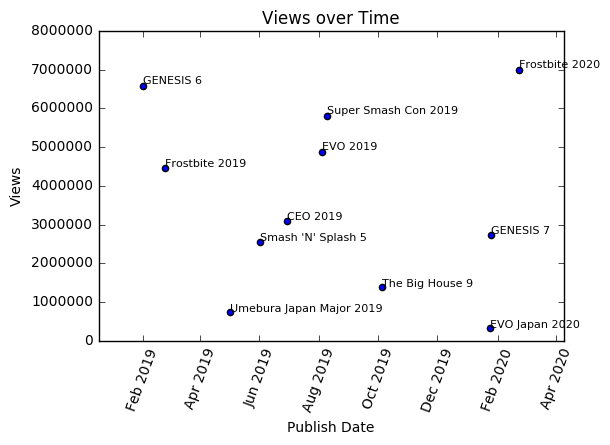

In [9]:
views_vs_publish_date=smash_videos[['video_views','tournament','published_date']].groupby(smash_videos.tournament).agg({'video_views':'sum','published_date':'first','tournament':'first'})
views_vs_publish_date.published_date=pd.to_datetime(views_vs_publish_date.published_date)
views_vs_publish_date=views_vs_publish_date.sort_values('published_date')
views_vs_publish_date=views_vs_publish_date.set_index('published_date')
x=views_vs_publish_date.index
y=views_vs_publish_date.video_views
plt.scatter(x,y)
for i in range(len(x)):
    plt.text(x[i],y[i]*1.01,views_vs_publish_date.tournament[i],fontsize=8)
plt.xticks(rotation=70)
plt.ylabel('Views')
plt.title('Views over Time')
plt.xlabel('Publish Date')
plt.ylim(0)
plt.show()


In [10]:
print('Views per Tournament')
smash_videos.video_views.groupby(smash_videos.tournament).sum()

Views per Tournament


tournament
CEO 2019                    3099149
EVO 2019                    4873077
EVO Japan 2020               329867
Frostbite 2019              4453771
Frostbite 2020              6975594
GENESIS 6                   6572319
GENESIS 7                   2726444
Smash 'N' Splash 5          2541248
Super Smash Con 2019        5798881
The Big House 9             1390655
Umebura Japan Major 2019     743211
Name: video_views, dtype: int64

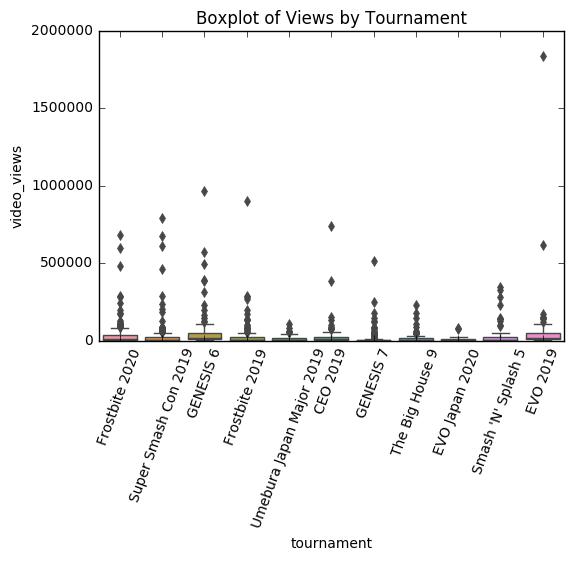

In [11]:
sns.boxplot(x=smash_videos.tournament,y=smash_videos.video_views)
plt.xticks(rotation=70)
plt.title('Boxplot of Views by Tournament')
plt.show()

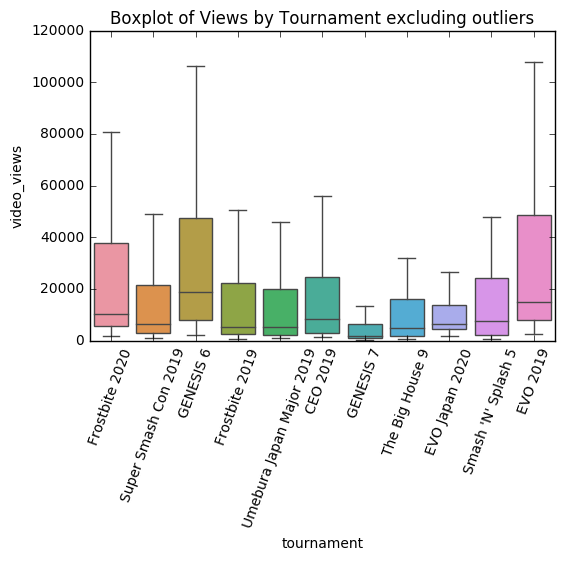

In [12]:
sns.boxplot(x=smash_videos.tournament,y=smash_videos.video_views,showfliers=False)
plt.xticks(rotation=70)
plt.title('Boxplot of Views by Tournament excluding outliers')

plt.show()

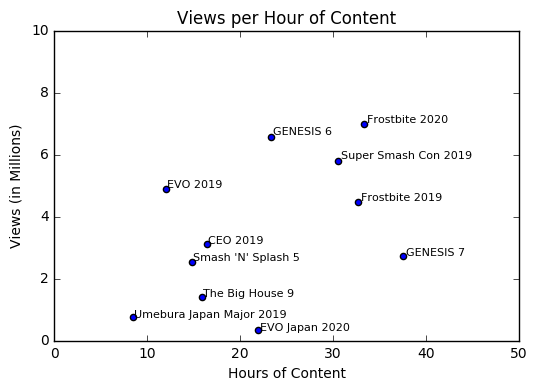

In [13]:
views_vs_length=smash_videos[['video_length','video_views']].groupby(smash_videos.tournament).agg({'video_length':'sum','video_views':'sum'})
x=views_vs_length['video_length'].dt.total_seconds()/3600.0
y=views_vs_length['video_views']/1000000.0
plt.scatter(x=x,y=y)
plt.xlabel('Hours of Content')
plt.ylabel('Views (in Millions)')
plt.ylim(0,10)
plt.xlim(0,50)
plt.title('Views per Hour of Content')
for i in range(len(x)):
    plt.text(x[i]*1.01,y[i]*1.01,x.index[i],fontsize=8)
plt.show()

/home/neil_s_oza/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


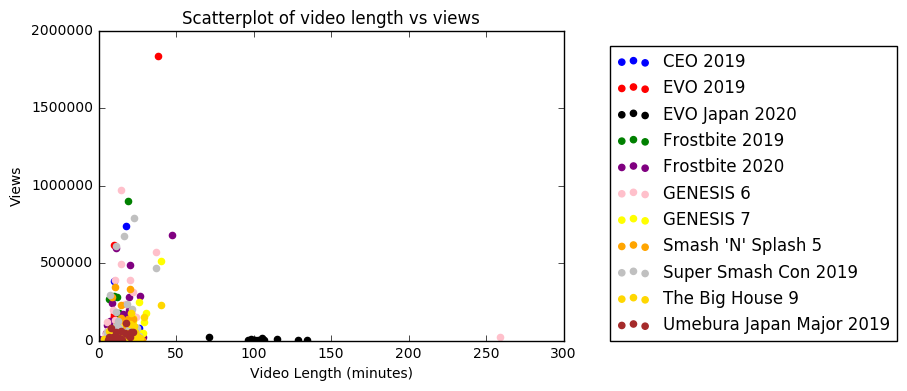

In [14]:
views_vs_length=smash_videos[['video_length','video_views']].groupby(smash_videos.tournament)
plt.plot()
i=0
colors=['blue','red','black','green','purple','pink', 'yellow', 'orange', 'silver','gold','brown']
for name, group in views_vs_length:
    
    group['color']=random.randrange(100)
    plt.scatter(x=group['video_length'].dt.total_seconds()/60,y=group['video_views'],label=name,color=colors[i])
    i=i+1
plt.title('Scatterplot of video length vs views')
plt.xlabel('Video Length (minutes)')
plt.ylabel('Views')
plt.ylim(0)
plt.xlim(0)

plt.legend(loc=[1.1,0])

plt.show()

The above five plots reveal some interesting trends. From a ratings perspective, the largest smash ultimate tournament in 2019 was the first one: Genesis 6. no other tournament in 2019 managed to match the spectator interest of the very first tournament. On the one hand this is expected because it was the first tournament after the games release, but on the other hand one would hope viewer interest increases over time. Frostbite 2020 managed increase viewership to almost 7 million total views. I attribute this to a combination of Smash World Tour hype and the fact it was the last tournament before the corona shutdown.

The two boxplots show the distribution of video views by video for each tournament. It turns out that most smash ultimate videos get between 5,000-20,000 views, with a handful of videos going viral, attaining 100,000 views+. Understanding what causes a video to reach that 100000k + threshold will be important to expanding spectator appeal.

There doesn't seem to be a strong correlation between video length and video views. If a video is over an hour long, no one will watch it, but videos as short as 10 minutes and as long as 50 minutes have gone viral. Also, only one video has ever attained over 1 million views, and that's EVO 2019 Grand Finals Tweek v MKLeo. If smash players want to make a living playing this game, that needs to improve significantly.

On that cheery note, let's move on to video titles. lets pull up some sample videos for reference

In [15]:
smash_videos.sample(20)

,video_title,video_length,video_views,published_date,tournament
938,Zenyou vs Samsora - Pools Winners' Semifinals: Ultimate Singles - TBH9 | Mario vs Daisy,00:10:49,7017,2019-10-06T01:27:10Z,The Big House 9
834,"Nairo vs Mystearica - Ultimate Singles: Pools R2 Winners SF - Genesis 7 |Palutena vs Zelda, Palutena",00:07:45,5659,2020-01-25T23:46:31Z,GENESIS 7
624,Umebura JM2019 SSBU - ProtoBanaham (Lucina) Vs. Choco (ZSS) Japan Smash Ultimate Tournament L. T12,00:06:52,6705,2019-05-02T05:40:28Z,Umebura Japan Major 2019
739,Schlocked vs Willy P - Ultimate Singles: Pools Round 2 - Genesis 7 | Wario vs Banjo,00:11:51,1578,2020-01-24T20:13:19Z,GENESIS 7
880,Tweek vs Meme - Ultimate Singles: Top 64 Winners Round 1 - Genesis 7 | Wario vs Yoshi,00:21:47,9517,2020-01-26T06:40:50Z,GENESIS 7
105,Frostbite 2020 SSBU Pools - TSM | Tweek (Wario) Vs. Ven (Zelda) Smash Ultimate Singles,00:10:05,23172,2020-02-23T03:44:55Z,Frostbite 2020
377,Genesis 6 SSBU - Babycakes (Donkey Kong) VS Sinai | Player 4 (Daisy) Smash Ultimate Pools,00:13:59,7226,2019-02-02T16:50:07Z,GENESIS 6
793,Blacktwins13 vs Tumultus - Ultimate Singles: Pools R1 Winners Finals - Genesis 7 | Pichu vs Palutena,00:12:07,1192,2020-01-25T05:56:15Z,GENESIS 7
350,Genesis 6 SSBU - Anti (Mario) VS WooF (Olimar) Smash Ultimate Pools,00:07:15,6963,2019-02-01T22:41:50Z,GENESIS 6
817,Prodigy vs Chubs - Ultimate Singles: Pools R1 Winners Final - Genesis 7 | Mario vs Yoshi,00:07:01,1104,2020-01-25T20:58:17Z,GENESIS 7


it's time to start analyzing video titles. Video titles are consistently formatted within a particular tournament, but different tournaments use different title formatting. let's isolate three examples for reference:

Larry Lurr vs Zinoto - Ultimate Singles: Pools R2 Winners Semifinal - Genesis 7 | Wolf vs Peach
Genesis 6 SSBU - FOX MVG | MKleo (Ike) Vs. GRV | Dabuz (Olimar) Smash Ultimate Tournament LS
TSM | Tweek (Wario/Wolf) vs. PG | Cosmos (Inkling) - Winners Semis - Frostbite 2019

most video titles contain 4 peices of information: the players, the characters used, the bracket/round, and the tournament name. none of this information is in any consistent order, and this causes problems. It is very difficult to extract info from a title without knowing the format. To illustrate this, suppose I wanted to find all videos where someone uses Fox. for most video titles, characters used in that video are placed in parentheses. However, some tournaments, such as Genesis 7, don't do this, and instead place characters used at the very end of the title. to find these occurences of Fox i would need to search the entire string for the word Fox, but if I did that, I would end up with false positives. For instance, the following would be considered a game with Fox:

Genesis 6 SSBU - FOX MVG | MKleo (Ike) Vs. GRV | Dabuz (Olimar) Smash Ultimate Tournament LS

MKleo's tag contains the word fox. In order to catch occurences of Fox in genesis 6, you end up with false positives in Gensis 7 and other tournaments. There are similar issues with identifying top 8 matches. most videos aren't labeled TOP 8. Instead they are often labeled winners semis or Losers Finals. Here's the problem with that:

Larry Lurr vs Zinoto - Ultimate Singles: Pools R2 Winners Semifinal - Genesis 7 | Wolf vs Peach

Pools matches have winners finals, winners semis, etc., just like top 8. Whenever I try to find all of the top 8 matches and group them I end up with a bunch of pools matches in the mix. I could create an individual parsing algorithm for each tournament, but that's a lot of work, and I would have to do it again for every new tournament. Instead I would like to make a request of the community. From now on, title smash ultimate sets using the following format

player1 (character1, character2, character3) vs player2 (character1, character2, character3)-Round-Format-Tournament

I recommend putting the players and characters first, because thats what viewers care the most about. Characters should be put in parentheses so that they are easy to distinguish from names. The round, format, and tournament should be seperated by - for easy parsing. Standard formatting is a small thing but it would go a long way 


I may come back and extract more data from the titles in the future, but for now I will use the titles to identify the characters used in sets when the characters are stored in parentheses. I will identify the number of characters used in the set and the names of those characters. If the video title does not store the character name in parentheses, it's number_of_characters and characters_in_set columns will be left blank. The below block of code accomplishes that for us

In [16]:
smash_characters=set([])
smash_videos['number_of_characters']=0
smash_videos['characters_in_set']=""
for row in range(len(smash_videos)):
    characters_in_set=re.findall('\(([^)]+)',smash_videos.iloc[row,0]) 
    for i in characters_in_set:
        individual_characters=re.split('[,/]+',i)
        smash_videos.iloc[row,5]+=len(individual_characters)
        for j in range(len(individual_characters)):
            smash_videos.iloc[row,6]+='-'+individual_characters[j].strip()
            smash_characters.add(individual_characters[j].strip().lower())
smash_videos.sample(10)

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
576,Ryuga (Ike) vs. SST | Shuton (Olimar) - Losers Top 8 Qualifier - Frostbite 2019,00:11:36,5169,2019-02-24T23:46:52Z,Frostbite 2019,2,-Ike-Olimar
323,SSC 2019 SSBU - NRG Nairo (Palutena) VS FOX MVG MkLeo (Joker) Smash Ultimate Loser's Quarters,00:21:29,204633,2019-08-12T03:17:44Z,Super Smash Con 2019,2,-Palutena-Joker
16,Frostbite 2020 SSBU Pools - MkLeo (Joker) Vs. Arconi (Meta Knight) Smash Ultimate Singles - SSBU,00:07:50,75763,2020-02-22T17:42:02Z,Frostbite 2020,2,-Joker-Meta Knight
969,Dabuz vs Maister - Top 8 Winners' Finals: Ultimate Singles - TBH9 | Olimar vs Game & Watch,00:24:56,9639,2019-10-07T04:51:40Z,The Big House 9,0,
559,UtopianRay (Palutena) vs. WBG | MVD (Snake) - Top 48 - Frostbite 2019,00:16:00,2618,2019-02-24T21:42:46Z,Frostbite 2019,2,-Palutena-Snake
1082,"EVO 2019 SSBU - Zenyou (Mario) Vs. ZerO.exe (Lucina, Inkling) Smash Ultimate Tournament Pools",00:07:58,12291,2019-08-03T20:04:46Z,EVO 2019,3,-Mario-Lucina-Inkling
847,Glutonny vs Dakpo - Ultimate Singles: Pools R2 Winners Semifinal - Genesis 7 | Wario vs Diddy Kong,00:12:33,36072,2020-01-26T02:44:33Z,GENESIS 7,0,
871,Tweek vs Kofi - Ultimate Singles: Pools R2 Winners Semifinal - Genesis 7 | Wario vs Falco,00:08:29,3409,2020-01-26T05:44:45Z,GENESIS 7,0,
346,Genesis 6 SSBU - FOX MVG | MkLeo (Ike) VS Condor Correct (Shulk) Smash Ultimate Pools,00:05:21,26392,2019-02-01T21:48:21Z,GENESIS 6,2,-Ike-Shulk
324,SSC 2019 SSBU - eUnited Samsora (Peach) VS TSM Tweek (Trainer) Smash Ultimate Winner's Finals,00:16:30,54267,2019-08-12T03:34:31Z,Super Smash Con 2019,2,-Peach-Trainer


The two new rows look accurate. Now that we have character information for a lot of the videos, we can see if certain characters are more popular than others and if sets with more characters get more views. Let's start by analyzing the effect of number of characters on view count, since that's simpler

In [17]:
a=smash_videos.video_views.groupby(smash_videos.number_of_characters).agg('mean')
b=smash_videos.video_views.groupby(smash_videos.number_of_characters).agg('median')
c=smash_videos.video_views.groupby(smash_videos.number_of_characters).agg('count')
character_count_views=pd.DataFrame([a,b,c])
character_count_views.index=['average_views','median_views','number_of_videos']
character_count_views

number_of_characters,0,2,3,4
average_views,17036.969811,37636.862162,43543.644068,124999.4375
median_views,3086.000000,9176.500000,7265.500000,21957.0000
number_of_videos,265.000000,740.000000,118.000000,16.0000


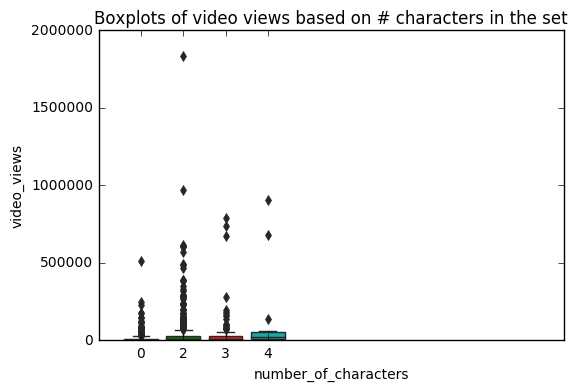

In [18]:
sns.boxplot(smash_videos.number_of_characters,smash_videos.video_views)
plt.xlim(-1,10)
plt.ylim(0,2000000)
plt.title('Boxplots of video views based on # characters in the set')
plt.show()

If number_of_characters=0, that means the video did not encapsulate the characters in parentheses. 2 means both players used exactly one character,3 means one player switched character midset, and 4 means fun things happened #NoBias. Some interesting trends. Firstly, videos that do not put the characters used inside parentheses get significantly fewer views, 20000 fewer on average and 5000 fewer views in median. TO's and Youtuber's, PLEASE put characters that are used in a set within parentheses. It will make analysis easier and it will get you more views.

There is some evidence suggesting more characters per set leads to more views, but the evidence isn't strong. Games with 4 characters average 125k views while games with  2 characters average 37k views. However, there were only 16 games total which featured 4 characters so the sample size isn't large enough to use as conclusive evidence. The median also suggests that 4 characters lead to more views than 2 characters, but interestingly the median set with 2 characters has more views than the median set with 3 characters. This might have something to do with counterpicking being more common in pools, but i'm not sure.

Dittos are recorded under 2 because each player picked 1 character. This is a bug. I would like Dittos to be represented by a 1 character count, but I will fix this later. There are no measurements for 5+ characters in a set because it doesn't happen

That was an overview of the impact that number of characters has on a video's views. Now let's see if certain characters are more popular than others. Are there fan favorites? To figure this out let's group videos by the characters used in them. This is a bit harder than it sounds, because some characters go by multiple names. I'll show you what I mean

In [19]:
smash_videos.sample(20)

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
787,Venia vs Death Arcana - Ultimate Singles: Pools R1 Winners Final - Genesis 7 | Greninja vs Toon Link,00:07:57,1940,2020-01-25T05:47:35Z,GENESIS 7,0,
824,Lui$ vs Blacktwins13 - Ultimate Singles: Pools R2 Winners Semifinal - Genesis 7 | Fox vs Pichu,00:14:14,1462,2020-01-25T23:12:56Z,GENESIS 7,0,
431,Genesis 6 SSBU - Dabuz (Olimar) Vs. Zackray (Wolf) Smash Ultimate Tournament LQ,00:22:54,70605,2019-02-04T08:45:00Z,GENESIS 6,2,-Olimar-Wolf
144,Frostbite 2020 SSBU Winners Quarters - NFT | Toast (Young Link) Vs SSG | Maister (G&W) Smash Singles,00:13:55,37186,2020-02-23T21:52:48Z,Frostbite 2020,2,-Young Link-G&W
22,Frostbite 2020 SSBU Pools - Naga (Marth) Vs. Gidy (Roy) Ultimate Singles - SSBU,00:06:16,4116,2020-02-22T18:05:25Z,Frostbite 2020,2,-Marth-Roy
45,Frostbite 2020 SSBU Pools - TG | MVD (Snake) Vs Aexw (Zero Suit Samus) Smash Ultimate Singles - SSBU,00:07:59,4792,2020-02-22T20:34:26Z,Frostbite 2020,2,-Snake-Zero Suit Samus
772,Magister vs Bulby - Ultimate Singles: Pools R1 Winners Finals - Genesis 7 | Incineroar vs G&W,00:15:22,2790,2020-01-25T04:07:21Z,GENESIS 7,0,
404,Genesis 6 SSBU - eU | Samsora (Peach) VS La Luna (Palutena) Smash Ultimate R2 Pools,00:07:58,8365,2019-02-03T01:00:56Z,GENESIS 6,2,-Peach-Palutena
469,HIKARU (Donkey Kong/Wario) vs. MTS | Suarez (Yoshi) - Ultimate Pools - Frostbite 2019,00:14:01,11538,2019-02-23T19:42:55Z,Frostbite 2019,3,-Donkey Kong-Wario-Yoshi
811,August vs Indignation - Ultimate Singles: Pools R1 Winners Round 1 - Genesis 7 | Inkling vs Link,00:10:44,503,2020-01-25T20:54:36Z,GENESIS 7,0,


Palutena goes by Palutena and Palu. Multiple characters have multiple names like this. Below is a lst of all character names used in these smash videos

In [20]:
smash_characters

{'banjo',
 'bayonetta',
 'bowser',
 'brawler',
 'byleth',
 'c. falcon',
 'c.falcon',
 'captain falcon',
 'captian falcon',
 'chrom',
 'cloud',
 'corrin',
 'daisy',
 'dark pit',
 'dark samus',
 'dedede',
 'diddy',
 'diddy kong',
 'dk',
 'doctor mario',
 'donkey kong',
 'duck hunt',
 'duckhunt',
 'falco',
 'falcon',
 'fox',
 'g&w',
 'game & watch',
 'ganon',
 'ganondorf',
 'greninja',
 'hero',
 'ice climbers',
 'icies',
 'ike',
 'incineroar',
 'ink',
 'inking',
 'inkling',
 'isabelle',
 'jigglypuff',
 'joker',
 'k. rool',
 'ken',
 'king dedede',
 'king k. rool',
 'kirby',
 'l. mac',
 'link',
 'little mac',
 'lucario',
 'lucas',
 'lucina',
 'luigi',
 'mac',
 'mario',
 'marth',
 'mega man',
 'meta knight',
 'mewtwo',
 'mii brawler',
 'mii gunner',
 'mii sword',
 'mii swordfighter',
 'mr. g&w',
 'ness',
 'olimar',
 'pac-man',
 'palu',
 'palutena',
 'peach',
 'pichu',
 'pikachu',
 'piranha plant',
 'pit',
 'pokemon trainer',
 'pokémon trainer',
 'pt',
 'puff',
 'richter',
 'ridley',
 'rob',


These names should be grouped together if we want an accurate reading of character popularity. This isn't too hard. However, if a new psuedonym is used in the future, that psuedonym must manually be added to the code. For instance, if someone decides to call young link ylink in a future video, the code must be told that ylink is just another name for young link. With that in mind, let's aggregate!

In [21]:
videos_by_character={}
for character in smash_characters:
    sets_with_character=smash_videos[smash_videos.characters_in_set.str.lower().str.contains('-'+character)]
    videos_by_character[character]=sets_with_character


In [22]:
#lets consolidate duplicate entris
videos_by_character['captain falcon']=pd.concat([videos_by_character['captain falcon'],videos_by_character['c. falcon'],videos_by_character['c.falcon'],videos_by_character['captian falcon'],videos_by_character['falcon']])
videos_by_character.pop('c. falcon',None)
videos_by_character.pop('c.falcon',None)
videos_by_character.pop('captian falcon',None)
videos_by_character.pop('falcon',None)
videos_by_character['diddy kong']=pd.concat([videos_by_character['diddy kong'],videos_by_character['diddy']])
videos_by_character.pop('diddy',None)
videos_by_character['donkey kong']=pd.concat([videos_by_character['donkey kong'],videos_by_character['dk']])
videos_by_character.pop('dk',None)
videos_by_character['duck hunt']=pd.concat([videos_by_character['duck hunt'],videos_by_character['duckhunt']])
videos_by_character.pop('duckhunt',None)
videos_by_character['game & watch']=pd.concat([videos_by_character['mr. g&w'],videos_by_character['game & watch'],videos_by_character['g&w']])
videos_by_character.pop('g&w',None)
videos_by_character.pop('mr. g&w',None)
videos_by_character['ganondorf']=pd.concat([videos_by_character['ganon'],videos_by_character['ganondorf']])
videos_by_character.pop('ganon',None)
videos_by_character['ice climbers']=pd.concat([videos_by_character['ice climbers'],videos_by_character['icies']])
videos_by_character.pop('icies',None)
videos_by_character['inkling']=pd.concat([videos_by_character['inkling'],videos_by_character['ink'],videos_by_character['inking']])
videos_by_character.pop('inking',None)
videos_by_character.pop('ink',None)
videos_by_character['jigglypuff']=pd.concat([videos_by_character['jigglypuff'],videos_by_character['puff']])
videos_by_character.pop('puff',None)
videos_by_character['king k. rool']=pd.concat([videos_by_character['king k. rool'],videos_by_character['k. rool']])
videos_by_character.pop('k. rool',None)
videos_by_character['king dedede']=pd.concat([videos_by_character['king dedede'],videos_by_character['dedede']])
videos_by_character.pop('dedede',None)
videos_by_character['little mac']=pd.concat([videos_by_character['little mac'],videos_by_character['l. mac'],videos_by_character['mac']])
videos_by_character.pop('l. mac',None)
videos_by_character.pop('mac',None)
videos_by_character['mii brawler']=pd.concat([videos_by_character['mii brawler'],videos_by_character['brawler']])
videos_by_character.pop('brawler',None)
videos_by_character['mii swordfighter']=pd.concat([videos_by_character['mii swordfighter'],videos_by_character['swordfighter'],videos_by_character['mii sword']])
videos_by_character.pop('swordfighter',None)
videos_by_character.pop('mii sword',None)
videos_by_character['palutena']=pd.concat([videos_by_character['palutena'],videos_by_character['palu']])
videos_by_character.pop('palu',None)
videos_by_character['pokemon trainer']=pd.concat([videos_by_character['pokemon trainer'],videos_by_character['pt'],videos_by_character['trainer'],videos_by_character['pokémon trainer']])
videos_by_character.pop('pt',None)
videos_by_character.pop('trainer',None)
videos_by_character.pop('pokémon trainer',None)
videos_by_character['rosalina & luma']=pd.concat([videos_by_character['rosalina & luma'],videos_by_character['rosa'],videos_by_character['rosalina']])
videos_by_character.pop('rosa',None)
videos_by_character.pop('rosalina',None)
videos_by_character['wii fit trainer']=pd.concat([videos_by_character['wii fit trainer'],videos_by_character['wft']])
videos_by_character.pop('wft',None)
videos_by_character['young link']=pd.concat([videos_by_character['y. link'],videos_by_character['y.link'],videos_by_character['young link']])
videos_by_character.pop('y.link',None)
videos_by_character.pop('y. link',None)
videos_by_character['zero suit samus']=pd.concat([videos_by_character['zero suit samus'],videos_by_character['zss']])
videos_by_character.pop('zss',None)
videos_by_character['zelda']=pd.concat([videos_by_character['zelda'],videos_by_character['zekda']])
videos_by_character.pop('zekda',None)
videos_by_character.keys()

dict_keys(['captain falcon', 'mewtwo', 'meta knight', 'lucas', 'king dedede', 'snake', 'ganondorf', 'joker', 'ken', 'little mac', 'incineroar', 'young link', 'luigi', 'falco', 'rob', 'pac-man', 'sonic', 'king k. rool', 'pikachu', 'corrin', 'doctor mario', 'ice climbers', 'wii fit trainer', 'ryu', 'chrom', 'donkey kong', 'palutena', 'dark pit', 'lucario', 'yoshi', 'isabelle', 'marth', 'greninja', 'shulk', 'ridley', 'fox', 'wario', 'pit', 'robin', 'cloud', 'ness', 'toon link', 'pichu', 'rosalina & luma', 'hero', 'kirby', 'villager', 'olimar', 'bayonetta', 'mii gunner', 'link', 'bowser', 'mega man', 'ike', 'daisy', 'richter', 'roy', 'diddy kong', 'game & watch', 'simon', 'pokemon trainer', 'sheik', 'terry', 'mii brawler', 'mii swordfighter', 'banjo', 'piranha plant', 'peach', 'duck hunt', 'samus', 'inkling', 'lucina', 'zelda', 'byleth', 'wolf', 'mario', 'zero suit samus', 'dark samus', 'jigglypuff'])

In [23]:
views_per_character=pd.DataFrame(columns=['character','median_views','video_count'])
counter=0
for character in videos_by_character:
    views_per_character.loc[counter, 'character']=character
    views_per_character.loc[counter, 'median_views']=videos_by_character[character].video_views.median()
    views_per_character.loc[counter, 'video_count']=len(videos_by_character[character])
    counter+=1
views_per_character.sort('median_views',ascending=False).reset_index(drop=True)

/home/neil_s_oza/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,character,median_views,video_count
0,byleth,344223,2
1,corrin,143930,2
2,terry,125650,1
3,ganondorf,45750,13
4,sheik,45571,9
5,luigi,36223,17
6,joker,36117,83
7,captain falcon,29936,28
8,marth,24831.5,4
9,jigglypuff,24380,5


The above table shows the median number of views a character gets per video. Byleth, Corrin, and Terry all have median view counts over 100k because they are rare characters that were used in top 8's or other high stakes sets. This suggests that viewers like high character variety at high levels of play. When they get it they give you a lot of extra views. 

The table organizes the characters from most median views to fewest median views, so the characters at the top are the most popular. Considering characters with at least 10 vudeos, the 5 most popular characters from a spectator's perspective are Ganondorf, Luigi, Joker, Captain Falcon, and Wario. Note that TOP TIER=/= popular. ROB, Roy, and Palutena are all Top Tier characters, but viewers don't like watching them. OHKO's are very popular with viewers. Jigglypuff, Luigi, and Wario all basically have a tactical nuke in their back pocket, and it seems viewers like watching them go off.

In my opinion, the above table highly suggests adjusting Smash Ultimate's ruleset to increase character diversity. Unexpected character picks get tons of views, and certain characters are way more popular than oters; if your grand finals involves a Palutena main, it's not going to do well. If somehow you can encourage the Palutena main to play Ganondorf, that video=hype. 

Armada says that Smash Ultimate has a lot of characters, but Melee's characters are deeper. If that's true, play to your strength. Lean into the character diversity. Even if Melee's mechanics are deeper, you win in breadth.

## Appendix/Misc.

That concludes the bulk of my analysis. We looked at video views over time, based on video duration, and based on character diversity. Below are peices of code that never quite led anywhere. I wanted to do some analysis, but due to time/resource limitations I will save these parts for another day. Feel free to pick at them yourself if you are bored

The below shows characters organized by their average views. The data is similar to the results from the median. I used Median instead of mean in my analysis because the mean is more senssitive to outliers

In [24]:
views_per_character=pd.DataFrame(columns=['character','average_views','video_count'])
counter=0
for character in videos_by_character:
    views_per_character.loc[counter, 'character']=character
    views_per_character.loc[counter, 'median_views']=videos_by_character[character].video_views.mean()
    views_per_character.loc[counter, 'video_count']=len(videos_by_character[character])
    counter+=1
views_per_character.sort('average_views',ascending=False).reset_index(drop=True)

/home/neil_s_oza/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,character,average_views,video_count,median_views
0,captain falcon,NaN,28,72791.250000
1,mewtwo,NaN,4,13359.750000
2,meta knight,NaN,12,56947.416667
3,lucas,NaN,8,6338.500000
4,king dedede,NaN,6,4266.666667
5,snake,NaN,80,26257.062500
6,ganondorf,NaN,13,42483.846154
7,joker,NaN,83,143949.325301
8,ken,NaN,6,111915.333333
9,little mac,NaN,10,18964.500000


Below are all of the videos with over 100k views. I wanted to analyze what causes a video to hit 100k views, but analyzing the titles for all the relevant information was tricky. Also, sometimes a video gets 100k views because it was an upset, and that sort of stuff is hard to identify using video titles. I understand that smash gg might have this bracket info. I don't know how to get it, but if I had it I could merge it with the video view data. I the meantime here is a list of all the videos with over 100k views. Let me know if you see any cool patterns!

In [25]:
smash_videos[smash_videos.video_views>100000]

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
24,Frostbite 2020 SSBU Pools - NEO! (Luigi) Vs. Armada | Elegant (Luigi) Ultimate Singles - SSBU,00:05:21,100066,2020-02-22T18:20:26Z,Frostbite 2020,2,-Luigi-Luigi
51,Frostbite 2020 SSBU Pools - Liquid | Hungrybox (Puff) Vs. RFang (Young Link) Smash Ultimate Singles,00:07:33,127558,2020-02-22T21:27:23Z,Frostbite 2020,2,-Puff-Young Link
98,Frostbite 2020 SSBU Pools - Armada | Prodigy (Mario) Vs. Riddles (Terry) Smash Ultimate Singles,00:10:02,125650,2020-02-23T02:53:12Z,Frostbite 2020,2,-Mario-Terry
99,Frostbite 2020 SSBU Pools - APE | Goblin (Roy) Vs. CLG | Void (Sheik) Smash Ultimate Singles,00:08:18,115944,2020-02-23T03:02:33Z,Frostbite 2020,2,-Roy-Sheik
125,Frostbite 2020 SSBU Winners Top 96 - MkLeo (Joker) Vs. Armada | Prodigy (Mario) Smash Ultimate,00:11:18,599665,2020-02-23T19:11:14Z,Frostbite 2020,2,-Joker-Mario
135,"Frostbite 2020 SSBU Winners Top 96 - GW | zackray (G&W, ROB) Vs. CLG | VoiD (Sheik) Smash Singles",00:15:36,171816,2020-02-23T20:31:07Z,Frostbite 2020,3,-G&W-ROB-Sheik
136,"Frostbite 2020 SSBU Losers Top 32 - MkLeo (Joker) Vs MVG | Salem (Hero, Dark Samus) Ultimate Singles",00:19:27,196469,2020-02-23T21:10:51Z,Frostbite 2020,3,-Joker-Hero-Dark Samus
139,Frostbite 2020 SSBU Losers Top 24 - Armada | Prodigy (Mario) Vs. djb | MattyG (Chrom) Singles,00:13:59,108510,2020-02-23T21:20:48Z,Frostbite 2020,2,-Mario-Chrom
152,Frostbite 2020 SSBU Losers Top 24 - PG | Marss (ZSS) Vs GW | Zackray (Joker) Ultimate Singles,00:18:00,110543,2020-02-23T22:53:29Z,Frostbite 2020,2,-ZSS-Joker
154,Frostbite 2020 SSBU Losers Top 16 - GW | zackray (ROB) Vs. Armada | Elegant (Luigi) Ultimate Singles,00:08:55,240567,2020-02-23T23:12:01Z,Frostbite 2020,2,-ROB-Luigi


Below are character frequencies in 100k videos

In [26]:
views_100k=pd.DataFrame(columns=['character','median_views','video_count'])
counter=0
for character in videos_by_character:
    views_100k.loc[counter, 'character']=character
    views_100k.loc[counter, 'median_views']=videos_by_character[character][videos_by_character[character].video_views>100000].video_views.median()
    views_100k.loc[counter, 'video_count']=len(videos_by_character[character][videos_by_character[character].video_views>100000])
    counter+=1
views_100k.sort('median_views',ascending=False)

/home/neil_s_oza/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,character,median_views,video_count
73,byleth,681550,1
52,mega man,614391,1
8,ken,609893,1
25,donkey kong,586139,2
13,falco,462275,2
44,hero,435494,2
58,game & watch,426683,2
71,lucina,382834,7
18,pikachu,343535,2
42,pichu,315733,7


The below block of code gets all of the words in the titles. might be useful at some point

In [27]:
all_words_in_titles=set()
for row in range(len(smash_videos)):
    all_words=re.split('[)(,/| ]+',smash_videos.iloc[row,0].lower())
    for i in range(len(all_words)):
        all_words_in_titles.add(all_words[i])
all_words_in_titles

{'',
 'cage',
 'bearonstilts',
 '256',
 'eggs',
 'lucas',
 'tamim',
 'gidy',
 'kola',
 'raito',
 'larry',
 'mac',
 'mystearica',
 'game',
 'milk',
 'whitefang',
 'red',
 'hippo',
 'koi',
 'angryalph',
 'kusa',
 'alan',
 'toon',
 'sharp',
 'correct',
 'laksa',
 'kite',
 'palu',
 'l',
 'captainjack',
 'tadavidid',
 'a9',
 'dm',
 'toranoonisan',
 'yokainels',
 'burntsocks',
 'nietono',
 'ese',
 'hiero7',
 'dude',
 'day',
 'wonderbread',
 'richardicecube',
 'con',
 'phantom',
 'ecg',
 'bungllo',
 'bonren',
 'lr1',
 'plant',
 'cashew',
 'legit',
 'bringus',
 'blank-',
 'mugen',
 'regi',
 'finals:',
 'fp',
 'singles',
 "liquid'hungrybox",
 'wadi',
 'frostbie',
 'chrom',
 'melody',
 'rng',
 'tloreo',
 'z',
 'limewire',
 'carlos',
 'zenma',
 'celxius',
 'moist',
 'brr',
 'eu',
 '_seba_',
 'jabes',
 'interviews',
 'k9sbruce',
 'astrus',
 'burgandy',
 'jehtt',
 'abadango',
 'cyan',
 'diabeo',
 'fyc',
 'eon',
 'cosmos',
 'myth',
 'rool',
 'fishbait',
 'glacey',
 'dyr',
 'donkey',
 'yikes!',
 'nev

All videos that contain the word final. A lot of these are ools matches which made getting top 8 info tricky

In [28]:
smash_videos[smash_videos.video_title.str.lower().str.contains('final')].sample(20)

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
909,Shadow_PR vs Ryoku - Pools Winners' Semifinals: Ultimate Singles - TBH9 | Bayonetta vs Samus,00:09:23,1562,2019-10-04T23:59:50Z,The Big House 9,0,
837,Mystearica vs colinies - Ultimate Singles: Pools R2 Losers Quarterfinal - Genesis 7 |Palutena vs Roy,00:07:13,823,2020-01-25T23:49:25Z,GENESIS 7,0,
953,Nairo vs ScAtt - Top 64 Winners' Semifinals: Ultimate Singles - TBH9 | Palutena vs Snake,00:19:16,7446,2019-10-06T18:16:36Z,The Big House 9,0,
820,Goblin vs Pollo - Ultimate Singles: Pools R1 Winners Final - Genesis 7 | Roy vs Marth,00:08:23,2685,2020-01-25T21:00:01Z,GENESIS 7,0,
932,Toast vs TM4 - Pools Winners' Semifinals: Ultimate Singles - TBH9 | Young Link vs Ness,00:14:50,1791,2019-10-06T01:01:59Z,The Big House 9,0,
828,Stroder Ame vs Shoe - Ultimate Singles: Pools R2 Losers Quarterfinal - Genesis 7 | Greninja vs ZSS,00:08:45,1117,2020-01-25T23:15:35Z,GENESIS 7,0,
958,Samsora vs Maister - Top 64 Winners' Semifinals: Ultimate Singles - TBH9 | Daisy vs Game & Watch,00:15:23,18474,2019-10-06T20:08:42Z,The Big House 9,0,
760,NAKAT vs CaiusRed - Ultimate Singles: Pools R1 Winners Finals - Genesis 7 | Pichu vs Cloud,00:08:57,1175,2020-01-25T03:34:41Z,GENESIS 7,0,
832,Dabuz vs Banana Boy - Ultimate Singles: Pools R2 Winners Quarterfinals - Genesis 7 | Alph vs Yoshi,00:10:35,5432,2020-01-25T23:45:04Z,GENESIS 7,0,
916,Shaid vs Moon - Pools Losers' Quarterfinals: Ultimate Singles - TBH9 | Pichu vs Dark Samus,00:12:11,687,2019-10-05T02:49:44Z,The Big House 9,0,


It is hard to identify Top 8 matches based on video titles because there isn't consistent naming across the tournaments. In addition, a lot of pools matches have titles like Pools Winners Semifinals or Pools Loser Finals. These sort of titles make it hard to identify the true winners finals videos. In the future, please identify top 8 videos by Calling them top 8 in the video title. it would make analyzing trends much easier and effective. 

In [29]:
smash_videos[~smash_videos.video_title.str.lower().str.contains('pool')]

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
35,"Frostbite 2020 SSBU - Skilly (Hero, Palutena) Vs. Kazma (ROB) Ultimate Singles - SSBU",00:07:57,2657,2020-02-22T19:25:45Z,Frostbite 2020,3,-Hero-Palutena-ROB
107,Frostbite 2020 SSBU Winners Top 96 - PG | Marss (ZSS) Vs. SSG | LeoN (Bowser) Ultimate Singles,00:10:01,86312,2020-02-23T16:45:26Z,Frostbite 2020,2,-ZSS-Bowser
108,Frostbite 2020 SSBU Winners Top 96 - Roxas (Joker) Vs. R2G | Paseriman (Fox) Smash Ultimate Singles,00:10:34,7065,2020-02-23T16:46:17Z,Frostbite 2020,2,-Joker-Fox
109,Frostbite 2020 SSBU Winners Top 96 - PG | Marss (ZSS) Vs. SSG | LeoN (Bowser) Ultimate Singles,00:10:01,86312,2020-02-23T16:45:26Z,Frostbite 2020,2,-ZSS-Bowser
110,Frostbite 2020 SSBU Winners Top 96 - Roxas (Joker) Vs. R2G | Paseriman (Fox) Smash Ultimate Singles,00:10:34,7065,2020-02-23T16:46:17Z,Frostbite 2020,2,-Joker-Fox
111,Frostbite 2020 SSBU Winners Top 96 - SST | Shuton (Olimar) Vs. Armada | Elegant (Luigi) Singles,00:12:16,36223,2020-02-23T16:53:47Z,Frostbite 2020,2,-Olimar-Luigi
112,Frostbite 2020 SSBU Winners Top 96 - Liquid | Dabuz (Rosalina) Vs. MuteAce (Peach) Ultimate Singles,00:15:43,6764,2020-02-23T17:19:26Z,Frostbite 2020,2,-Rosalina-Peach
113,"Frostbite 2020 SSBU Winners Top 96 - djb | MattyG (Chrom, Wolf) Vs. SSG | Maister (Mr. G&W) Singles",00:14:54,9935,2020-02-23T17:23:18Z,Frostbite 2020,3,-Chrom-Wolf-Mr. G&W
114,Frostbite 2020 SSBU Winners Top 96 - eUnited | Samsora (Peach) Vs. Charliedaking (Wolf) Singles,00:16:20,19184,2020-02-23T17:21:52Z,Frostbite 2020,2,-Peach-Wolf
115,"Frostbite 2020 SSBU Winners Top 96 - R2G | Kameme (Sheik, Wario) Vs. Toast (Young Link) Singles",00:17:02,30083,2020-02-23T17:49:43Z,Frostbite 2020,3,-Sheik-Wario-Young Link


In [30]:
smash_videos[~smash_videos.video_title.str.lower().str.contains('pool')]

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
35,"Frostbite 2020 SSBU - Skilly (Hero, Palutena) Vs. Kazma (ROB) Ultimate Singles - SSBU",00:07:57,2657,2020-02-22T19:25:45Z,Frostbite 2020,3,-Hero-Palutena-ROB
107,Frostbite 2020 SSBU Winners Top 96 - PG | Marss (ZSS) Vs. SSG | LeoN (Bowser) Ultimate Singles,00:10:01,86312,2020-02-23T16:45:26Z,Frostbite 2020,2,-ZSS-Bowser
108,Frostbite 2020 SSBU Winners Top 96 - Roxas (Joker) Vs. R2G | Paseriman (Fox) Smash Ultimate Singles,00:10:34,7065,2020-02-23T16:46:17Z,Frostbite 2020,2,-Joker-Fox
109,Frostbite 2020 SSBU Winners Top 96 - PG | Marss (ZSS) Vs. SSG | LeoN (Bowser) Ultimate Singles,00:10:01,86312,2020-02-23T16:45:26Z,Frostbite 2020,2,-ZSS-Bowser
110,Frostbite 2020 SSBU Winners Top 96 - Roxas (Joker) Vs. R2G | Paseriman (Fox) Smash Ultimate Singles,00:10:34,7065,2020-02-23T16:46:17Z,Frostbite 2020,2,-Joker-Fox
111,Frostbite 2020 SSBU Winners Top 96 - SST | Shuton (Olimar) Vs. Armada | Elegant (Luigi) Singles,00:12:16,36223,2020-02-23T16:53:47Z,Frostbite 2020,2,-Olimar-Luigi
112,Frostbite 2020 SSBU Winners Top 96 - Liquid | Dabuz (Rosalina) Vs. MuteAce (Peach) Ultimate Singles,00:15:43,6764,2020-02-23T17:19:26Z,Frostbite 2020,2,-Rosalina-Peach
113,"Frostbite 2020 SSBU Winners Top 96 - djb | MattyG (Chrom, Wolf) Vs. SSG | Maister (Mr. G&W) Singles",00:14:54,9935,2020-02-23T17:23:18Z,Frostbite 2020,3,-Chrom-Wolf-Mr. G&W
114,Frostbite 2020 SSBU Winners Top 96 - eUnited | Samsora (Peach) Vs. Charliedaking (Wolf) Singles,00:16:20,19184,2020-02-23T17:21:52Z,Frostbite 2020,2,-Peach-Wolf
115,"Frostbite 2020 SSBU Winners Top 96 - R2G | Kameme (Sheik, Wario) Vs. Toast (Young Link) Singles",00:17:02,30083,2020-02-23T17:49:43Z,Frostbite 2020,3,-Sheik-Wario-Young Link


Videos with strange titles

In [31]:
strange_titles=smash_videos[smash_videos.video_title.apply(lambda x: False if 'vs' in x.lower() else True)]
strange_titles

,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
328,Super Smash Con 2019 - bc | EE Interviews FOX MVG | MkLeo,00:06:05,14670,2019-08-12T13:36:30Z,Super Smash Con 2019,0,
436,GENESIS 6 - ULTIMATE TOP 8,04:18:50,24767,2019-02-09T05:13:15Z,GENESIS 6,0,
519,Rogue | Light (Fox) v. MTS | Suarez (Yoshi) - Phase 2 Pools - Frostbite 2019,00:21:03,14897,2019-02-24T02:07:40Z,Frostbite 2019,2,-Fox-Yoshi
973,The Big House 9 - Recap,00:03:37,8378,2019-10-07T06:39:11Z,The Big House 9,0,
974,EVO Japan 2020 - Super Smash Bros. Ultimate - Pools Part 1 - Day 1,01:38:34,12323,2020-01-24T08:39:05Z,EVO Japan 2020,0,
975,EVO Japan 2020 - Super Smash Bros. Ultimate - Pools Part 2 - Day 1,01:42:46,5558,2020-01-24T08:52:01Z,EVO Japan 2020,0,
976,EVO Japan 2020 - Super Smash Bros. Ultimate - Pools Part 3 - Day 1,01:40:43,3100,2020-01-24T08:52:14Z,EVO Japan 2020,0,
977,EVO Japan 2020 - Super Smash Bros. Ultimate - Pools Part 4 - Day 1,01:46:24,4475,2020-01-24T09:39:02Z,EVO Japan 2020,0,
978,EVO Japan 2020 - Super Smash Bros. Ultimate - Pools Part 5 - Day 1,01:40:14,3409,2020-01-24T11:26:40Z,EVO Japan 2020,0,
979,EVO Japan 2020 - Super Smash Bros. Ultimate - Pools Part 6 - Day 1,02:14:18,5249,2020-01-24T13:26:52Z,EVO Japan 2020,0,


The ten most viewed videos in competitive smash history!

In [32]:
#Ten most viewed videos

smash_videos.sort('video_views',ascending=False).head(10)

/home/neil_s_oza/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,video_title,video_length,video_views,published_date,tournament,number_of_characters,characters_in_set
1138,EVO 2019 Smash Ultimate Grand Finals - TSM | Tweek (Pokemon Trainer) Vs. FOX | MkLeo (Joker),00:38:03,1836317,2019-08-05T06:04:24Z,EVO 2019,2,-Pokemon Trainer-Joker
417,Genesis 6 SSBU - FOX MVG | MkLeo (Ike) VS TSM | Leffen (Pokemon Trainer) Smash Ultimate W. Top 64,00:14:36,968613,2019-02-03T04:36:06Z,GENESIS 6,2,-Ike-Pokemon Trainer
585,FOX MVG | MkLeo (Ike/Lucina) vs. TSM | Tweek (DK/Wario) - Winners Finals - Frostbite 2019,00:18:57,902794,2019-02-25T03:12:08Z,Frostbite 2019,4,-Ike-Lucina-DK-Wario
311,"SSC 2019 SSBU - FOX MVG MkLeo (Joker) VS GW Zackray (Wolf, ROB) Smash Ultimate Winner's Quarters",00:23:01,789602,2019-08-11T19:35:49Z,Super Smash Con 2019,3,-Joker-Wolf-ROB
733,"CEO 2019 SSBU - FOX | MkLeo (Joker) Vs. PG | Marss (ZSS, Falcon) Smash Ultimate Grand Finals",00:17:37,739696,2019-07-01T03:43:42Z,CEO 2019,3,-Joker-ZSS-Falcon
170,"Frostbite 2020 SSBU Grand Finals - SSG Maister (G&W, Pichu) Vs MkLeo (Joker, Byleth) Smash Ultimate",00:47:17,681550,2020-02-24T05:57:26Z,Frostbite 2020,4,-G&W-Pichu-Joker-Byleth
241,"SSC 2019 SSBU - TSM Leffen (Trainer) VS MVG Salem (Snake, Hero) Smash Ultimate Round 2 Pools",00:16:23,674518,2019-08-10T23:58:12Z,Super Smash Con 2019,3,-Trainer-Snake-Hero
1112,EVO 2019 SSBU - FOX | MkLeo (Joker) Vs. R2G | Kameme (Mega Man) Smash Ultimate Tournament Top 32,00:10:01,614391,2019-08-04T03:26:45Z,EVO 2019,2,-Joker-Mega Man
250,SSC 2019 SSBU - FOX MVG MkLeo (Joker) VS Riddles (Ken) Smash Ultimate Round 2 Pools,00:11:05,609893,2019-08-11T02:13:34Z,Super Smash Con 2019,2,-Joker-Ken
125,Frostbite 2020 SSBU Winners Top 96 - MkLeo (Joker) Vs. Armada | Prodigy (Mario) Smash Ultimate,00:11:18,599665,2020-02-23T19:11:14Z,Frostbite 2020,2,-Joker-Mario
